# Przemysław Kaleta
Data: https://data.stanford.edu/hcmst2017

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import xgboost as xgb

from collections import defaultdict

In [3]:
data = pd.read_stata("hcmts.dta")

Explanations of variable names taken from:

https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf

* Yes/no questions:
    * **Q5** Is [Partner name] the same sex as you? 
    * **Q25_2** Did you and [Partner name] attend the same high school?
    * **Q26_2** Did you and [Partner name] attend the same college or university?
    * **hcm2017q24_met_online** Met online
    
* Quantitative questions:
    * **w6_q9** partner age in 2017
    * **w6_q24_length** length of q24 how met answer in characters

In [4]:
binary_variables = ["Q5", "Q25_2", "Q26_2",  "hcm2017q24_met_online"]
continuous_variables = ["w6_q9", "w6_q24_length"]
predicted_variables = ["S1"]
variables = binary_variables + continuous_variables + predicted_variables
mydata = data.loc[data.S1.notna(), variables]

## Model

In [5]:
# Dictionary with keys as columns of categorical variables 
# and values as functions which for a given code tell us what category it is
name_from_code = defaultdict(lambda: lambda x: x)

# usage: name_from_code["column_name"](code)
# If column name is not in binary variables name_from_code["column_name"] is an identity function.

for column_name in binary_variables + predicted_variables:
    
    column = mydata[column_name].values
    
    def _name_from_code(x, col=column):
        return col.from_codes([x], col.categories)[0]
    
    name_from_code[column_name] = _name_from_code
    
    mydata[column_name] = column.codes

In [6]:
X, y = mydata.drop("S1", axis=1), mydata["S1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

def test_classifier(y_true, y_pred):
    n = len(y_true)
    print(f"Positive/negative percentages in population: {sum(y_true) / n} / {sum(y_true == 0) / n}")
    print(f"Accuracy {sum(y_true == y_pred) / n}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    
test_classifier(y_test, y_pred)

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8076923076923077
F1 score: 0.7283702213279677


## Zmiana w średniej odpowiedzi modelu

Wylosujemy jakąś osobę z populacji i dla niej zbadamy jak jej kolejne cechy wpływały na odpowiedź modelu. Warto najpierw zauważyć, że osoba ta ma prawie 100% szansę według modelu na bycie w związku małżeńskim. Ponadto warto zwrócić uwagę, że pierwsza zmienna - Q5, czyli odpowiedź na pytanie czy partner ma taką samą płeć jest wartością nieznaną.

In [113]:
random.seed(1234)
random_person = X_train.iloc[random.choice(range(0, len(X_train)))]
random_person = pd.DataFrame([random_person.values], columns=X_train.columns)
print(random_person)
print("Predicted probabilities:", xgb_model.predict_proba(random_person))

    Q5  Q25_2  Q26_2  hcm2017q24_met_online  w6_q9  w6_q24_length
0 -1.0    2.0    1.0                    0.0   54.0          356.0
Predicted probabilities: [[2.757907e-04 9.997242e-01]]


In [71]:
column_order = ["Q5", "Q25_2", "Q26_2", "hcm2017q24_met_online", "w6_q9", "w6_q24_length"]

In [47]:
random.sample(column_order, len(column_order))

['hcm2017q24_met_online', 'Q26_2', 'Q5', 'Q25_2', 'w6_q24_length', 'w6_q9']

In [114]:
def get_mean_proba(model, data_subset):
    predictions = model.predict_proba(data_subset)
    return np.mean(predictions[:, 1])

def get_data_subset(X, person, i):
    """Returns subset of X for which """
    match = X.iloc[:, 0:(i+1)].values == person.iloc[:, 0:(i+1)].values
    indexes = np.apply_along_axis(all, 1, match)
    return X[indexes]

In [184]:
def get_attribution_probas(person, data, model, column_order):
    X = data.copy()[column_order]
    predicted_probas = [get_mean_proba(model, X)]
    for i in range(len(column_order), ):
        proba = get_mean_proba(model, get_data_subset(X, person, i))
        predicted_probas.append(proba)
    return predicted_probas

import waterfall_chart

def plot_attributions(person, data, model, column_order):
    probas = get_attribution_probas(person, data, model, column_order)
    waterfall_chart.plot(["Intercept"] + column_order, np.concatenate([[probas[0]], np.ediff1d(probas)]))

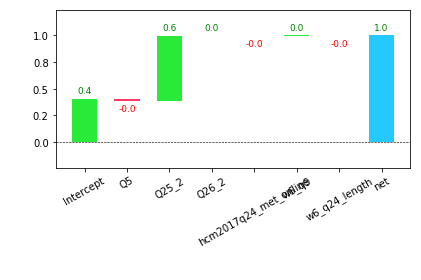

In [185]:
plot_attributions(random_person, X_train, xgb_model, column_order)